<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/dmi_02_loans_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# ---- Step 1: Load the Dataset ----
if 'google.colab' in str(get_ipython()):
    from google.colab import drive, data_table
    drive.mount('/content/drive', force_remount=True)
    file_path = '/content/drive/My Drive/Colab Notebooks/data-mining/data/train_ctrUa4K.csv'
    data_table.enable_dataframe_formatter()
else:
    file_path = './data/train_ctrUa4K.csv'  # Local path

Mounted at /content/drive


In [3]:
# Load the loan dataset
df = pd.read_csv(file_path)

In [4]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Dataset shape: (614, 13)
Columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
print(df.isnull().sum())

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [6]:
# Create a new TotalIncome column by summing ApplicantIncome and CoapplicantIncome
df['TotalIncome'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# Create a new Loan_Income_Ratio column by dividing LoanAmount by TotalIncome
df['Loan_Income_Ratio'] = df['LoanAmount'] / df['TotalIncome']

# Display the new features alongside the original columns to verify the results
print(df[['ApplicantIncome', 'CoapplicantIncome', 'TotalIncome', 'LoanAmount', 'Loan_Income_Ratio']].head())

   ApplicantIncome  CoapplicantIncome  TotalIncome  LoanAmount  \
0             5849                0.0       5849.0         NaN   
1             4583             1508.0       6091.0       128.0   
2             3000                0.0       3000.0        66.0   
3             2583             2358.0       4941.0       120.0   
4             6000                0.0       6000.0       141.0   

   Loan_Income_Ratio  
0                NaN  
1           0.021015  
2           0.022000  
3           0.024287  
4           0.023500  


In [7]:
df['Dependents'].describe()

,Dependents
count,599
unique,4
top,0
freq,345


In [8]:
# For numerical columns, fill missing values with the mean
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].mean())

# For categorical columns, fill missing values with the mode
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Check for remaining missing values
print(df.isnull().sum())

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
TotalIncome          0
Loan_Income_Ratio    0
dtype: int64


In [9]:
# Option 1: Use LabelEncoder for each categorical column
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Alternatively, with one-hot encoding
# df = pd.get_dummies(df, drop_first=True)

df.head(21)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,Loan_Income_Ratio
0,0,1,0,0,0,0,5849,0.0,146.412162,360.0,1.000000,2,1,5849.0,0.023756
1,1,1,1,1,0,0,4583,1508.0,128.000000,360.0,1.000000,0,0,6091.0,0.021015
2,2,1,1,0,0,1,3000,0.0,66.000000,360.0,1.000000,2,1,3000.0,0.022000
3,3,1,1,0,1,0,2583,2358.0,120.000000,360.0,1.000000,2,1,4941.0,0.024287
4,4,1,0,0,0,0,6000,0.0,141.000000,360.0,1.000000,2,1,6000.0,0.023500
5,5,1,1,2,0,1,5417,4196.0,267.000000,360.0,1.000000,2,1,9613.0,0.027775
6,6,1,1,0,1,0,2333,1516.0,95.000000,360.0,1.000000,2,1,3849.0,0.024682
7,7,1,1,3,0,0,3036,2504.0,158.000000,360.0,0.000000,1,0,5540.0,0.028520
8,8,1,1,2,0,0,4006,1526.0,168.000000,360.0,1.000000,2,1,5532.0,0.030369
9,9,1,1,1,0,0,12841,10968.0,349.000000,360.0,1.000000,1,0,23809.0,0.014658


In [10]:
# Calculate Income Per Capita by dividing TotalIncome by the household size
# df['IncomePerCapita'] = df['TotalIncome'] / (df['Dependents'] + 2)

In [11]:
# Drop irrelevant features ('Loan_ID' for example)
if 'Loan_ID' in df.columns:
    df.drop(['Loan_ID'], axis=1, inplace=True)

# Define target and features
target = 'Loan_Status'
# X = df.drop([target, 'ApplicantIncome', 'CoapplicantIncome'], axis=1)
X = df.drop([target, 'ApplicantIncome'], axis=1)

y = df[target]

print("Features:", X.columns.tolist())
print("Target:", target)

Features: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'TotalIncome', 'Loan_Income_Ratio']
Target: Loan_Status


In [12]:
# Split the dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (491, 12)
Test set size: (123, 12)


In [13]:
# Initialize the model without parameters
model = DecisionTreeClassifier(random_state=42)

# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(1, 11))
}

# Set up the grid search with 5-fold cross-validation and using F1-score as scoring metric
grid_search = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
result = grid_search.fit(X_train, y_train)

# Output best score and parameters
print("Best score using Decision Tree: %f with %s" % (result.best_score_*100, result.best_params_))

Best score using Decision Tree: 87.392389 with {'criterion': 'entropy', 'max_depth': 2}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_

{'criterion': 'entropy', 'max_depth': 2}

In [14]:
# Initialize and train a Decision Tree Classifier
tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)

print("Decision Tree model trained.")

Decision Tree model trained.


In [15]:
# Use the trained model to predict on the test set
y_pred = tree_clf.predict(X_test)

In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Compute and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Display the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Accuracy: 0.8211382113821138
Confusion Matrix:
 [[22 21]
 [ 1 79]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.51      0.67        43
           1       0.79      0.99      0.88        80

    accuracy                           0.82       123
   macro avg       0.87      0.75      0.77       123
weighted avg       0.85      0.82      0.80       123



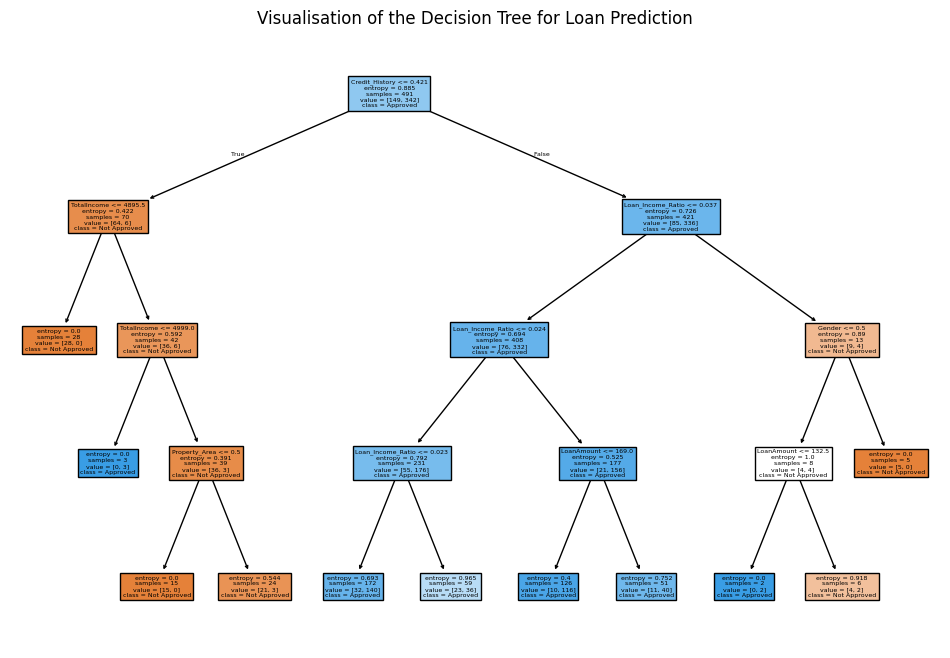

In [17]:
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=X.columns, class_names=["Not Approved", "Approved"], filled=True)
plt.title("Visualisation of the Decision Tree for Loan Prediction")
plt.show()
